In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance

# Import and Cleaning

In [3]:
df = pd.read_csv('E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,NLUZON,01SUAL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SMEC,-10000.0,...,647.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# specify selected price-quantity columns
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [5]:
pd.set_option('display.max_columns', None)

# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]

#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

In [6]:
# Convert 'run_time' to datetime with multiple formats
result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()

# Handle the remaining date-only format separately
mask_date_only = result_df['temp_run_time'].dt.time == pd.Timestamp('00:00:00').time()
result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='coerce', format='%m/%d/%Y')))

# Drop the temporary column
result_df.drop(columns=['temp_run_time'], inplace=True)

# Print the result
result_df.head()

C:\Users\Gaea\AppData\Local\Temp\ipykernel_27712\2423218759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['temp_run_time'] = pd.to_datetime(result_df['run_time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p').copy()
C:\Users\Gaea\AppData\Local\Temp\ipykernel_27712\2423218759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['temp_run_time'].where(mask_date_only, result_df['temp_run_time'].combine_first(pd.to_datetime(result_df['temp_run_time'], errors='c

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,NaT,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 00:05:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-26 00:10:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-26 00:15:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-26 00:20:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
starting_index = 6
downsampled_df = result_df.iloc[starting_index::12, :].copy()  # Use .copy() to create a copy of the DataFrame
downsampled_df.reset_index(drop=True, inplace=True)
downsampled_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,541.0,632.7,647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,450.0,538.2,556.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.2,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,435.0,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,NaN,NaN,NaN,NaN,0.0,350.0,436.9,456.0,560.0,600.0,647.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17309,2023-09-25 19:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17310,2023-09-25 20:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17311,2023-09-25 21:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN
17312,2023-09-25 22:20:00,-10000.0,-10000.0,5300.08,5700.08,6000.08,6500.08,7000.08,7400.08,7800.08,8000.08,NaN,0.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,647.0,NaN


## FFill NaNs with Last Price-Quantity Bid

In [8]:
# Forward fill from the first non-null value in each row for the price columns
downsampled_df.loc[:, 'price1':'price11'] = downsampled_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
downsampled_df.loc[:, 'quantity1':'quantity11'] = downsampled_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

downsampled_df.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2021-06-26 00:30:00,-10000.0,-10000.0,2214.38,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,2465.69,0.0,541.0,632.7,647.0,647.0,647.0,647.0,647.0,647.0,647.0,647.0
1,2021-06-26 01:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,450.0,538.2,556.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
2,2021-06-26 02:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.2,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
3,2021-06-26 03:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,435.0,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0
4,2021-06-26 04:30:00,-10000.0,-10000.0,2214.38,2465.69,2470.08,2480.08,2490.08,2490.08,2490.08,2490.08,2490.08,0.0,350.0,436.9,456.0,560.0,600.0,647.0,647.0,647.0,647.0,647.0


## MinMaxScaler on Quantity values

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = downsampled_df[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(downsampled_df[quantity_columns].shape)

# Update the DataFrame with the scaled values
downsampled_df.loc[:, quantity_columns] = scaled_quantities

# Filter df for only 2022

In [10]:
# Filter rows within the year 2022
df_2022 = downsampled_df[(downsampled_df['run_time'] >= '2022-01-01') & (downsampled_df['run_time'] < '2023-01-01')]

# Reset index
df_2022 = df_2022.reset_index(drop=True)
df_2022

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,quantity1,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,2022-01-01 00:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.426893,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-01-01 01:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.412056,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-01-01 02:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411747,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-01-01 03:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411283,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-01-01 04:15:00,-10000.0,-10000.0,2854.00,4638.61,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,15000.08,0.0,0.386399,0.411128,0.550232,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7943,2022-12-31 19:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7944,2022-12-31 20:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7945,2022-12-31 21:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0
7946,2022-12-31 22:30:00,-10000.0,-10000.0,9200.08,9260.08,9280.08,9300.08,9300.08,9300.08,9300.08,9300.08,9300.08,0.0,0.370943,0.540958,0.695518,0.836167,1.0,1.0,1.0,1.0,1.0,1.0


# K-medoids

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get values from columns
prices = df_2022[['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']].values
quantities = df_2022[['quantity1', 'quantity2', 'quantity3', 'quantity4', 'quantity5', 'quantity6', 'quantity7', 'quantity8', 'quantity9', 'quantity10', 'quantity11']].values

# Function to create step-wise bid curves
def create_stepwise_curves(prices, quantities):
    step_curves = []
    for i in range(len(prices)):
        step_curves.append(list(zip(quantities[i], prices[i])))
    return step_curves

step_curves = create_stepwise_curves(prices, quantities)

In [12]:
num_curves = len(step_curves)
length_of_first_curve = len(step_curves[0]) if num_curves > 0 else 0

print(f"Number of curves: {num_curves}")
print(f"Length of the first curve: {length_of_first_curve}")

Number of curves: 7948
Length of the first curve: 11


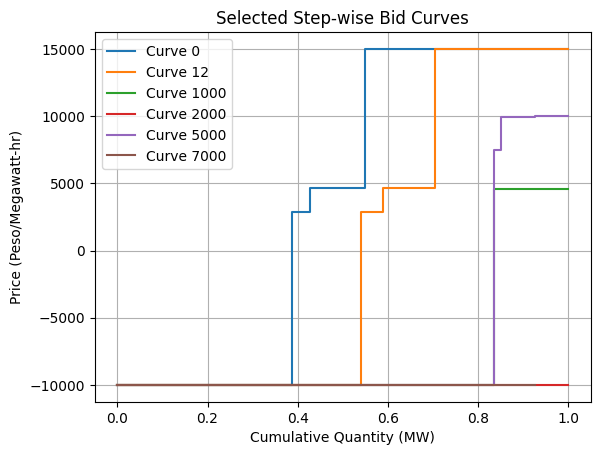

In [13]:
# Test Plot random indices
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 1000, 2000, 5000, 7000]

# Extract prices and cumulative quantities for the specified indices
selected_prices = df_2022.iloc[indices_to_plot, 1:12].values  # Assuming columns 'price1' to 'price11'
selected_cumulative_quantities = df_2022.iloc[indices_to_plot, 12:23].values  # Assuming columns 'quantity1' to 'quantity11'

# Plotting the selected step-wise bid curves
for i in range(len(indices_to_plot)):
    cumulative_quantity = selected_cumulative_quantities[i]
    price = selected_prices[i]
    plt.step(cumulative_quantity, price, where='pre', label=f'Curve {indices_to_plot[i]}')

plt.xlabel('Cumulative Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Selected Step-wise Bid Curves')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Change step_curves into numpy array
step_curves_array = np.array(step_curves).reshape(len(step_curves), -1)

In [15]:
print("Shape of step_curves_array:", step_curves_array.shape)

Shape of step_curves_array: (7948, 22)


In [16]:
# Adjust the slicing to select the first num entries
subset_step_curves_array = step_curves_array[:2000]

## K-medoids process for entire array

In [17]:
# %%time
# from sklearn_extra.cluster import KMedoids
# from scipy.stats import wasserstein_distance
# from tqdm.notebook import tqdm
# from joblib import Parallel, delayed

# # Function to calculate Wasserstein distance
# def wasserstein_dist(p1, p2):
#     return wasserstein_distance(p1, p2)

# # Function to perform K-medoids clustering
# def kmedoids_clustering(data, k):
#     kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
#     kmedoids.fit(data)
#     return kmedoids.labels_, kmedoids.cluster_centers_

# # Function to calculate Separation Threshold
# def separation_threshold_ratio(labels, centers, theta_0, p_ref):
#     k = len(centers)
#     s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
#     s_th = theta_0 * s_ref
    
#     for i in range(k):
#         distances_within_cluster = [
#             wasserstein_dist(subset_step_curves_array[j], centers[i]) 
#             for j in range(len(labels)) if labels[j] == i
#         ]
#         rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

#         if rho_i > RHO_0:
#             return True

#     return False

# # Parameters
# K_0 = 2
# K_max = 10  # Choose a smaller value for testing
# THETA_0 = 0.01  # 1% as THETA_0
# RHO_0 = 0.1

# # Initial chunk size
# initial_chunk_size = 10

# # Reduce memory usage
# subset_step_curves_array = subset_step_curves_array.astype(np.float32)

# # Initialization
# K = K_0
# P_ref = subset_step_curves_array[0]  # Using the first curve as reference

# optimal_K = K_0  # Initialize the variable to track the optimal number of clusters

# centers_list = []  # Store cluster centers here

# with tqdm(total=K_max - K_0 + 1, desc="Iterating through K clusters") as pbar:
#     while K <= K_max:  # Adjust the loop condition to check against K_max
#         pbar.set_postfix({"Current K": K})

#         # Dynamic chunk size based on remaining clusters
#         remaining_clusters = K_max - K
#         chunk_size = min(initial_chunk_size, remaining_clusters)

#         print(f"Processing chunk for K={K}")

#         def process_chunk(_):
#             labels, centers = kmedoids_clustering(subset_step_curves_array, K)
#             return separation_threshold_ratio(labels, centers, THETA_0, P_ref), centers

#         # Use `list()` to force the progress bar to update in a Jupyter Notebook
#         chunk_results = list(Parallel(n_jobs=-1)(delayed(process_chunk)(_) for _ in range(chunk_size)))

#         for result, centers in chunk_results:
#             if result:
#                 optimal_K = K  # Update the optimal_K variable
#                 centers_list.append(centers)
#                 break
#         else:
#             break  # Break out of the loop if K_max is reached or exceeded

#         pbar.update(chunk_size)

#         # Print additional information every 100 iterations
#         if K % 100 == 0:
#             print(f"Current iteration: {K}, Result: {result}")

#         # Increment K after the loop update for correct display
#         K += chunk_size

# # Now optimal_K contains the optimal number of clusters, up to K_max
# print(f"Optimal number of clusters (K): {optimal_K}")


In [18]:
# # Assuming 'centers_list' is your list of cluster centers
# final_centers = centers_list[-1]

# # Assuming 'final_centers' is your cluster centers
# num_features = final_centers.shape[1]
# feature_columns = [f'quantity{i//2 + 1}' if i % 2 == 0 else f'price{i//2 + 1}' for i in range(num_features - 2)]
# centers_df = pd.DataFrame(final_centers[:, 2:], columns=feature_columns)

# centers_df


In [19]:
# # Assuming 'centers_df' is your DataFrame
# for i in range(len(centers_df)):
#     cumulative_quantity, price = zip(*centers_df.iloc[i].values.reshape(-1, 2))
#     plt.step(cumulative_quantity, price, where='pre', label=f'Center {i + 1}')

# plt.xlabel('Quantity (MW)')
# plt.ylabel('Price (Peso/Megawatt-hr)')
# plt.title('Bid Curves for Cluster Centers')
# plt.legend()
# plt.grid(True)
# plt.show()


## K-medoids process

In [20]:
%%time
from sklearn_extra.cluster import KMedoids
from scipy.stats import wasserstein_distance
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Function to calculate Wasserstein distance
def wasserstein_dist(p1, p2):
    return wasserstein_distance(p1, p2)

# Function to perform K-medoids clustering
def kmedoids_clustering(data, k):
    kmedoids = KMedoids(n_clusters=k, metric=wasserstein_dist, random_state=42)
    kmedoids.fit(data)
    return kmedoids.labels_, kmedoids.cluster_centers_

# Function to calculate Separation Threshold
def separation_threshold_ratio(labels, centers, theta_0, p_ref):
    k = len(centers)
    s_ref = wasserstein_dist(centers[0], p_ref)  # Assuming P_ref is the first center
    s_th = theta_0 * s_ref
    
    for i in range(k):
        distances_within_cluster = [
            wasserstein_dist(subset_step_curves_array[j], centers[i]) 
            for j in range(len(labels)) if labels[j] == i
        ]
        rho_i = sum(1 for dist in distances_within_cluster if dist > s_th) / len(distances_within_cluster)

        if rho_i > RHO_0:
            return True

    return False

# Function to process a chunk
def process_chunk(K):
    labels, centers = kmedoids_clustering(subset_step_curves_array, K)
    return separation_threshold_ratio(labels, centers, THETA_0, P_ref), centers

# Parameters
K_0 = 2
K_max = 20  # Choose a smaller value for testing
THETA_0 = 0.01  # 1% as THETA_0
RHO_0 = 0.1

# Initial chunk size
initial_chunk_size = 100
# Number of iterations within each chunk
iterations_within_chunk = 5

# Reduce memory usage
subset_step_curves_array = subset_step_curves_array.astype(np.float32)

# Initialization
K = K_0
P_ref = subset_step_curves_array[0]  # Using the first curve as a reference

optimal_K = K_0  # Initialize the variable to track the optimal number of clusters

centers_list = []  # Store cluster centers here

with tqdm(total=K_max - K_0 + 1, desc="Iterating through K clusters") as pbar:
    while K <= K_max:  # Adjust the loop condition to check against K_max
        pbar.set_postfix({"Current K": K})

        # Dynamic chunk size based on remaining clusters
        remaining_clusters = K_max - K
        chunk_size = min(initial_chunk_size, remaining_clusters)

        print(f"Processing chunk for K={K}")

        result_found = False  # Flag to track whether a result was found in the inner loop

        for _ in range(iterations_within_chunk):
            # Use `list()` to force the progress bar to update in a Jupyter Notebook
            chunk_results = list(Parallel(n_jobs=-1)(delayed(process_chunk)(K + i) for i in range(chunk_size)))

            for result, centers in chunk_results:
                if result:
                    optimal_K = K  # Update the optimal_K variable
                    centers_list.append(centers)
                    result_found = True
                    break

            if result_found:
                break  # Break out of the inner loop if a result is found

            pbar.update(1)  # Update the progress bar after each iteration within the chunk

            # Print additional information every 100 iterations
            if K % 100 == 0:
                print(f"Current iteration: {K}, Result: {result}")

        if result_found:
            break  # Break out of the outer loop if a result is found

        # Increment K after the chunk is processed
        K += chunk_size

# Now optimal_K contains the optimal number of clusters, up to K_max
print(f"Optimal number of clusters (K): {optimal_K}")

Iterating through K clusters:   0%|          | 0/19 [00:00<?, ?it/s]

Processing chunk for K=2
Optimal number of clusters (K): 2
CPU times: total: 188 ms
Wall time: 2min 30s


In [21]:
# Assuming 'centers_list' is your list of cluster centers
final_centers = centers_list[-1]

# Assuming 'final_centers' is your cluster centers
num_features = final_centers.shape[1]
feature_columns = [f'quantity{i//2 + 1}' if i % 2 == 0 else f'price{i//2 + 1}' for i in range(num_features - 2)]
centers_df = pd.DataFrame(final_centers[:, 2:], columns=feature_columns)

centers_df


,quantity1,price1,quantity2,price2,quantity3,price3,quantity4,price4,quantity5,price5,quantity6,price6,quantity7,price7,quantity8,price8,quantity9,price9,quantity10,price10
0,0.540958,-10000.0,0.597991,2862.199951,0.704791,4646.810059,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078,1.0,15000.080078
1,0.836167,-10000.0,0.876198,2862.199951,1.000000,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059,1.0,4646.810059


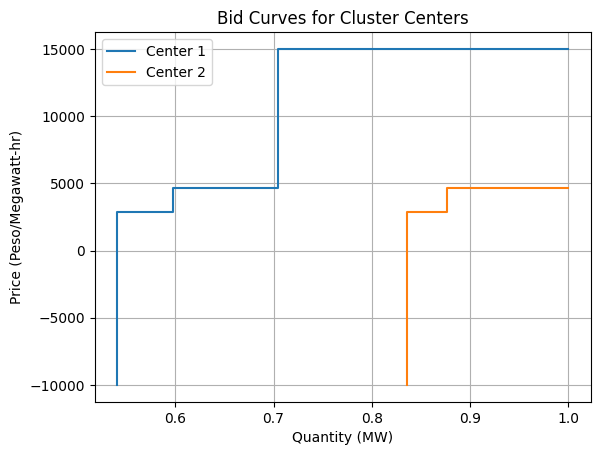

In [22]:
# Assuming 'centers_df' is your DataFrame
for i in range(len(centers_df)):
    cumulative_quantity, price = zip(*centers_df.iloc[i].values.reshape(-1, 2))
    plt.step(cumulative_quantity, price, where='pre', label=f'Center {i + 1}')

plt.xlabel('Quantity (MW)')
plt.ylabel('Price (Peso/Megawatt-hr)')
plt.title('Bid Curves for Cluster Centers')
plt.legend()
plt.grid(True)
plt.show()


# [ARCHIVED] Sampling the bid curve

In [ ]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022

# Reset the index of test_df
test_df.reset_index(drop=True, inplace=True)

In [ ]:
%%time
# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for 'pre' step-wise interpolation
    step_fx = interp1d(quantities, prices, kind='previous', fill_value='extrapolate')

    # Get the original quantities for interpolation
    intp_quantities = np.array(quantities)

    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)

    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000

    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

## Export Price series

In [ ]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

In [ ]:
all_prices_array = np.array(all_prices)
all_prices_array

In [ ]:
# # Specify the CSV file path
csv_file_path = 'E:\Documents\Google Drive\Eskwelabs\Sprint 5 - Capstone\data\consolidated_csv_01SUAL_G01_price_series_nointerp.csv'

# # Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

## Plot select bid curves

In [ ]:
# Find the index where 'price5' first becomes equal to 30k
index_first_32000 = test_df[test_df['price5'] == 30000.08]['price5'].idxmax()
index_first_32000

In [ ]:
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 1000, 6348, 11424, 20000, 30000, 40000, 62187]
# indices_to_plot = [6348]

In [ ]:
# Plot only the selected stepwise curves on a single graph
plt.figure(figsize=(10, 6))

for i, (quantities, prices, intp_quantities, intp_prices) in enumerate(tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing')):
    if i in indices_to_plot:
        plt.step(quantities, prices, where='pre', label=f'Curve_{i}')
        plt.scatter(intp_quantities, intp_prices, color='red')

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Selected Stepwise Graphs and Interpolated Prices')
plt.legend()
plt.show()

In [ ]:
# Display the rows at specified indices
rows_to_display = test_df.loc[indices_to_plot]
rows_to_display

# K-medoids Chunking Attempt

In [ ]:
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # Import tqdm.notebook for Jupyter Notebook

In [ ]:
# Function to calculate Wasserstein distance between two curves
def wasserstein_distance_between_curves(curve1, curve2):
    return wasserstein_distance(curve1, curve2)

# Function to calculate the proportion RHO_i
def calculate_proportion(distances, threshold):
    exceeding_threshold = np.sum(distances > threshold)
    return exceeding_threshold / len(distances)

In [ ]:
def run_kmedoids_with_warnings(bidding_curves, K, theta_0, rho_0, s_ref, chunk_size):
    kmedoids = KMedoids(n_clusters=K)

    # Initialize variables
    k_t = K
    s_th = theta_0 * s_ref
    rho_0_percentage = rho_0 * 100

    # Use tqdm for the outer loop only
    for chunk_start in tqdm(range(0, len(bidding_curves), chunk_size), desc='Processing Chunks', leave=False, bar_format=''):
        chunk_end = min(chunk_start + chunk_size, len(bidding_curves))
        chunk = bidding_curves[chunk_start:chunk_end]

        if len(chunk) < K:
            # Skip chunks with insufficient samples for K-medoids
            continue

        try:
            kmedoids.fit(chunk)
            cluster_centers = kmedoids.cluster_centers_
        except UserWarning as e:
            print(f"Warning: {e}")
            continue

        distances = Parallel(n_jobs=-1)(
            delayed(wasserstein_distance_between_curves)(cluster_center, curve) for cluster_center in tqdm(cluster_centers, desc='Calculating Distances', leave=False) for curve in bidding_curves
        )

        # Check if the proportion exceeds the tolerance rate
        rhos = [calculate_proportion(distances, s_th) for _ in cluster_centers]

        if any(rho > rho_0 for rho in rhos):
            k_t += 1

    return k_t, cluster_centers

# Main iterative procedure to find the optimal number of clusters
def find_optimal_k(bidding_curves, k_max, theta_0, rho_0, chunk_size=100):
    k_0 = 2
    k_t = k_0

    # Calculate the Wasserstein distance between the initial two cluster centers
    s_ref = wasserstein_distance_between_curves(bidding_curves[0], bidding_curves[1])

    while k_t <= k_max:
        k_t, cluster_centers = run_kmedoids_with_warnings(bidding_curves, k_t, theta_0, rho_0, s_ref, chunk_size)

    return k_t, cluster_centers

In [ ]:
%%time
# bidding_curves should be a 2D array where each row represents a bidding curve
# Adjust the values of k_max, theta_0, and rho_0 as needed
k_max = 30
theta_0 = 0.01  # 1% of the Wasserstein distance between the initial two cluster centers
rho_0 = 0.1  # Tolerance rate
chunk_size = 1000

# Call the main function to find the optimal number of clusters and get cluster centers
optimal_k, optimal_cluster_centers = find_optimal_k(all_intp_prices, k_max, theta_0, rho_0, chunk_size)

In [ ]:
optimal_k

In [ ]:
optimal_cluster_centers

# K-medoids, 1st 1000 only

In [ ]:
import numpy as np
from scipy.stats import wasserstein_distance
from sklearn_extra.cluster import KMedoids
from joblib import Parallel, delayed
from tqdm import tqdm

# Function to calculate Wasserstein distance between two curves
def wasserstein_distance_between_curves(curve1, curve2):
    return wasserstein_distance(curve1, curve2)

# Function to calculate the proportion RHO_i
def calculate_proportion(distances, threshold):
    exceeding_threshold = np.sum(distances > threshold)
    return exceeding_threshold / len(distances)

In [ ]:
# Function to run K-medoids clustering and check if the clusters meet the criteria
def run_kmedoids_and_check_clusters(bidding_curves, K, theta_0, rho_0, s_ref):
    kmedoids = KMedoids(n_clusters=K)
    kmedoids.fit(bidding_curves)
    cluster_centers = kmedoids.cluster_centers_

    # Initialize variables
    k_t = K
    s_th = theta_0 * s_ref
    rho_0_percentage = rho_0 * 100

    for i, cluster_center in enumerate(cluster_centers):
        distances = Parallel(n_jobs=-1)(
            delayed(wasserstein_distance_between_curves)(cluster_center, curve) for curve in tqdm(bidding_curves, desc='Calculating Distances')
        )

        # Check if the proportion exceeds the tolerance rate
        rho_i = calculate_proportion(distances, s_th)

        if rho_i > rho_0:
            k_t += 1
            break

    return k_t, cluster_centers

# Main iterative procedure to find the optimal number of clusters
def find_optimal_k(bidding_curves, k_max, theta_0, rho_0):
    k_0 = 2
    k_t = k_0

    # Calculate the Wasserstein distance between the initial two cluster centers
    s_ref = wasserstein_distance_between_curves(bidding_curves[0], bidding_curves[1])

    while k_t <= k_max:
        k_t, cluster_centers = run_kmedoids_and_check_clusters(bidding_curves, k_t, theta_0, rho_0, s_ref)

    return k_t, cluster_centers

In [ ]:
# Truncate each array in the list to the first 10 entries
truncated_intp_prices = all_intp_prices[:1000]

# Truncate each array in the list to the first 10 entries
truncated_intp_quantity = all_intp_quantities[:1000]

In [ ]:
# bidding_curves should be a 2D array where each row represents a bidding curve
# Adjust the values of k_max, theta_0, and rho_0 as needed
k_max = 30
theta_0 = 0.01  # 1% of the Wasserstein distance between the initial two cluster centers
rho_0 = 0.1  # Tolerance rate

In [ ]:
%%time
# Call the main function to find the optimal number of clusters and get cluster centers
optimal_k, optimal_cluster_centers = find_optimal_k(truncated_intp_prices, k_max, theta_0, rho_0)

In [ ]:
optimal_k

In [ ]:
optimal_cluster_centers

In [ ]:
# Plot truncated_intp_quantity against optimal cluster centers
plt.figure(figsize=(10, 6))

for i, (cluster_prices, intp_quantity) in enumerate(tqdm(zip(optimal_cluster_centers, truncated_intp_quantity), desc='Processing')):
    plt.step(intp_quantity, cluster_prices, where='pre', label=f'Cluster_{i}', linestyle='--')  # Adjust linestyle as needed

# Customize the plot as needed
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Truncated Interpolated Quantities and Optimal Cluster Centers')
plt.legend()
plt.show()

# [Archived] previous code

In [ ]:
#Set Qmax
Q_max = 647.0

In [ ]:
# Bidding curve sampling procedure
def bidding_curve_sampling(row):
    M = 11  # Set M to 10
    delta_q_i = Q_max / M
    q_sp = np.arange(0, Q_max + delta_q_i, delta_q_i)[:M]  # Adjust the range

    p_sp = []
    for i in range(1, M + 1):
        price_col = f'price{i}'
        quantity_col = f'quantity{i}'
        p_sp.append(row[price_col])

    return pd.Series({'P^SP': p_sp, 'q^SP': q_sp})

# Apply bidding curve sampling to each row (DU_i)
bidding_curve_df = result_df.apply(bidding_curve_sampling, axis=1)

# Unifying the data length by normalizing the bidding quantity
def normalize_bidding_curve(row):
    normalized_quantity = row['q^SP'] / Q_max
    return pd.Series({'q(m)': normalized_quantity, 'P^SP': row['P^SP']})

# Apply data normalization to each row
normalized_curve_df = bidding_curve_df.apply(normalize_bidding_curve, axis=1)

In [ ]:
# Indices to plot (adjust as needed)
indices_to_plot = [0, 12, 108308, 109147, 112940, 116309, 121374]

# Plot the bidding curves for the specified indices using plt.step
for index, row in normalized_curve_df.loc[indices_to_plot].iterrows():
    plt.step(row['q(m)'], row['P^SP'], label=f'Bid_{index}', where='post')

plt.axvline(x=1.0, color='red', linestyle='--', label='Bidding Quantity = 1.0')

plt.ylabel('Bidding Price')
plt.xlabel('Normalized Bidding Quantity')
plt.title('Normalized Bidding Curves for Specific Indices')
plt.legend()
plt.show()


In [ ]:
bidding_curve_df

In [ ]:
# Access the 'q^SP' column for the 12th index
contents = bidding_curve_df.at[0, 'q^SP']

# Print the contents
print("Contents of index in 'q^SP' column:")
print(contents)

In [ ]:
normalized_curve_df

In [ ]:
# Access the 'q^SP' column for the 12th index
cont = normalized_curve_df.at[0, 'q(m)']

# Print the contents
print("Contents of index in 'q(m)' column:")
print(cont)